### Salish Sea Zooplankton
Comparing monthly zooplankton biomass from Salish Sea Cast with zooplankton in Atlantis

In [1]:
import arrow
import os
from datetime import datetime, timedelta
import itertools
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as sgeom
import xarray as xr
from cartopy import crs, feature
from pathlib import Path
from IPython.display import Image
from shapely.geometry import MultiPoint
from mpl_toolkits.axes_grid1 import make_axes_locatable

from salishsea_tools import data_tools, places, nc_tools, wind_tools

### Read in SalishSeaCast monthly mean zooplankton biomass from 2007-2020 (Suchy et al., 2025)

In [2]:
ssc_data_path = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/"
monthly_array_mesozoo_depthint_slicemean = pd.read_csv(ssc_data_path+"SSC201905_monthly_mesozoo.csv")
monthly_array_microzoo_depthint_slicemean = pd.read_csv(ssc_data_path+"SSC201905_monthly_microzoo.csv")

In [3]:
ssc_mesozoo_monthly_mean = monthly_array_mesozoo_depthint_slicemean.mean(axis=0)
ssc_mesozoo_std = monthly_array_mesozoo_depthint_slicemean.std(axis=0)

ssc_microzoo_monthly_mean = monthly_array_microzoo_depthint_slicemean.mean(axis=0)
ssc_microzoo_std = monthly_array_microzoo_depthint_slicemean.std(axis=0)

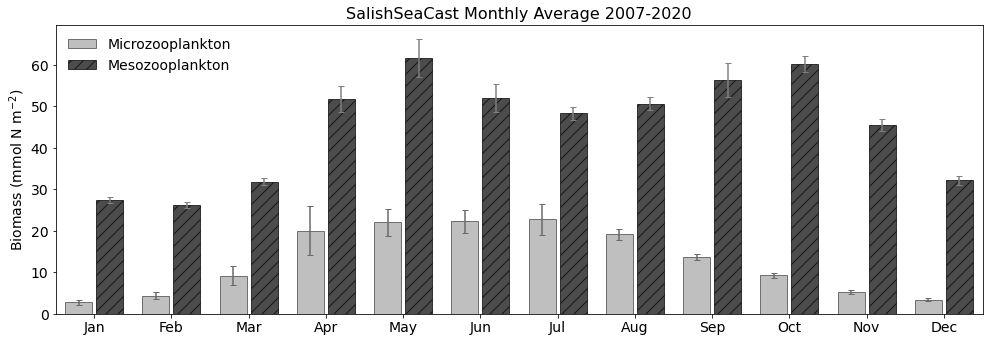

In [6]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_mesozoo_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_microzoo_monthly_mean,width,yerr=ssc_microzoo_std,color='grey',ecolor='dimgrey',edgecolor='k',label='Microzooplankton',alpha=0.5,capsize=3) 
ax.bar(xticks + 0.2, ssc_mesozoo_monthly_mean,width,yerr=ssc_mesozoo_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='Mesozooplankton') 
ax.set_title('SalishSeaCast Monthly Average 2007-2020',fontsize=16)
ax.legend(frameon=False,fontsize=14,loc="upper left")
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Biomass (mmol N m$^{-2}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Read in corresponding SSAM mesozoo for central SoG, 100 m depth-integrated

In [72]:
# Central Strait of Gerorgia
central_sog_boxes = [81,82,83]

In [73]:
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df_original = gpd.read_file(shapefile_name)
data_df_original = data_df_original.sort_values(by=['BOX_ID'])
data_df = data_df_original.set_index('BOX_ID')
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]
land_df = data_df.loc[land_boxes]
ssc_match_df = data_df.loc[central_sog_boxes]

In [74]:
grid = xr.open_dataset('/data/bmoorema/MEOPAR/grid/bathymetry_201702.nc', mask_and_scale=False)
pointList = []
boxCSoGcorners = (450,250), (450, 300), (500,300), (500,250), (450,250) #250, 450
for i in boxCSoGcorners: 
    pointList.append(sgeom.Point(float(grid.nav_lon[i]), float(grid.nav_lat[i])))
bbox = sgeom.Polygon([[p.x, p.y] for p in pointList])


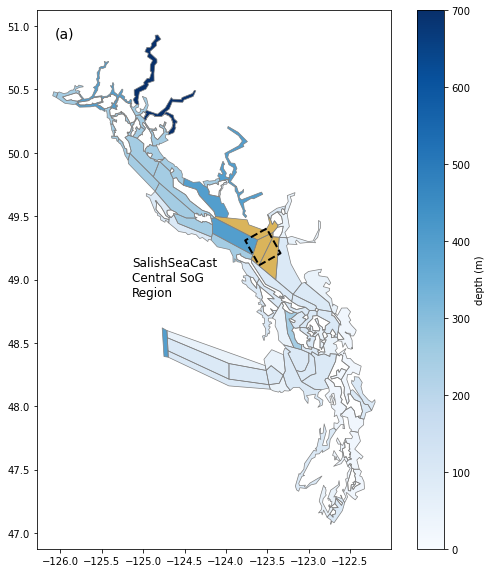

In [75]:
# Atlantis Location Map with SalishSeaCast Box Location
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)

ax = data_df.plot(column = 'BOTZ', ax=ax, cmap=cm.Blues, cax=cax,
    legend=True, legend_kwds={'label': 'depth (m)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
ssc_match_df.plot(ax=ax, color='orange',  alpha=0.6, linewidths=0.5, label='matching Atlantis polygons')
land_df.plot(ax=ax, color='white')
#ax.annotate(0.81, 0.55, 'Matching\nAtlantis\nPolygons',transform=ax.transAxes, color='orange', fontsize=12)
ax.text(0.27, 0.47, 'SalishSeaCast\nCentral SoG\nRegion',transform=ax.transAxes, color='black', fontsize=12)
ax.text(0.05, 0.95, '(a)', transform=ax.transAxes, color='black', fontsize=14,) #fontweight='bold'
bbox_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:4326", geometry=[bbox])
bbox_gdf = bbox_gdf.to_crs(data_df.crs)
bbox_gdf.boundary.plot(ax=ax, edgecolor='black', linewidths=2, linestyle="--", label='SalishSeaCast\nCentral SoG\nRegion');

In [12]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Control/v6719_14y_20250703/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True) #.resample(t='1M').mean()


In [34]:
data_df['Zoo'] = control.Zoo_N.sum(axis=2).mean(axis=0)
data_df['MicroZoo'] = control.MicroZoo_N.sum(axis=2).mean(axis=0)
data_df['GelatZoo'] = control.Gelat_Zoo_N.sum(axis=2).mean(axis=0)

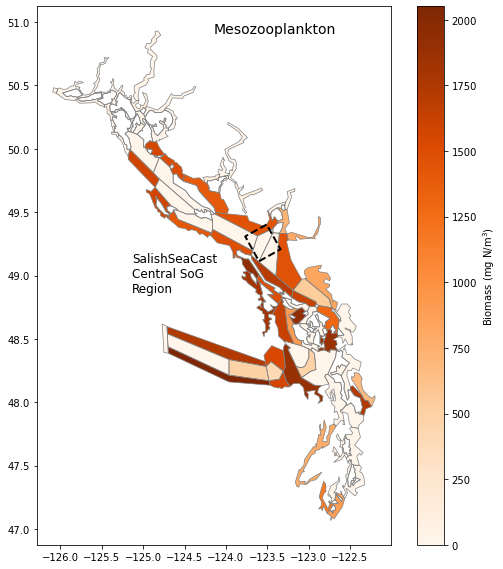

In [32]:
# Atlantis Location Map with SalishSeaCast Box Location
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)

ax = data_df.plot(column = 'Zoo', ax=ax, cmap=cm.Oranges, cax=cax,
    legend=True, legend_kwds={'label': 'Biomass (mg N/m$^3$)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#ssc_match_df.plot(ax=ax, color='orange',  alpha=0.6, linewidths=0.5, label='matching Atlantis polygons')
land_df.plot(ax=ax, color='white')
#ax.annotate(0.81, 0.55, 'Matching\nAtlantis\nPolygons',transform=ax.transAxes, color='orange', fontsize=12)
ax.text(0.27, 0.47, 'SalishSeaCast\nCentral SoG\nRegion',transform=ax.transAxes, color='black', fontsize=12)
ax.text(0.5, 0.95, 'Mesozooplankton', transform=ax.transAxes, color='black', fontsize=14,) #fontweight='bold'
bbox_gdf.boundary.plot(ax=ax, edgecolor='black', linewidths=2, linestyle="--", label='SalishSeaCast\nCentral SoG\nRegion');

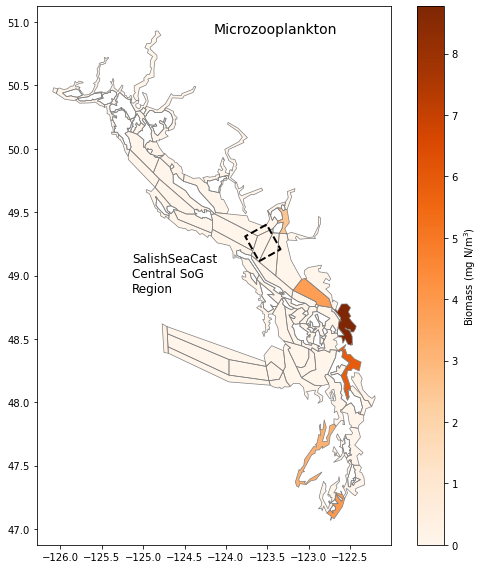

In [33]:
# Atlantis Location Map with SalishSeaCast Box Location
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)

ax = data_df.plot(column = 'MicroZoo', ax=ax, cmap=cm.Oranges, cax=cax,
    legend=True, legend_kwds={'label': 'Biomass (mg N/m$^3$)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#ssc_match_df.plot(ax=ax, color='orange',  alpha=0.6, linewidths=0.5, label='matching Atlantis polygons')
land_df.plot(ax=ax, color='white')
#ax.annotate(0.81, 0.55, 'Matching\nAtlantis\nPolygons',transform=ax.transAxes, color='orange', fontsize=12)
ax.text(0.27, 0.47, 'SalishSeaCast\nCentral SoG\nRegion',transform=ax.transAxes, color='black', fontsize=12)
ax.text(0.5, 0.95, 'Microzooplankton', transform=ax.transAxes, color='black', fontsize=14,) #fontweight='bold'
bbox_gdf.boundary.plot(ax=ax, edgecolor='black', linewidths=2, linestyle="--", label='SalishSeaCast\nCentral SoG\nRegion');

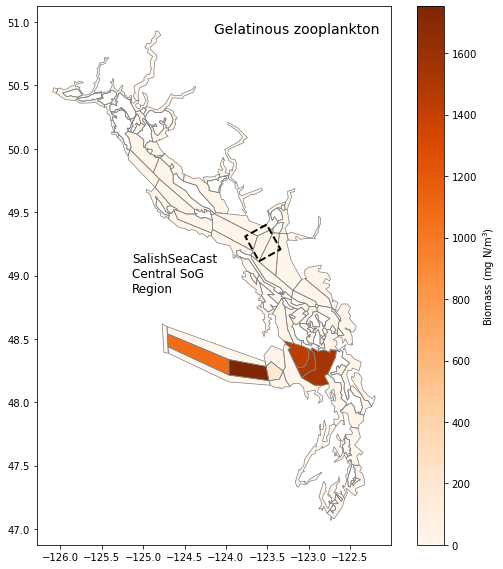

In [35]:
# Atlantis Location Map with SalishSeaCast Box Location
fig, ax = plt.subplots(figsize=(9,12), facecolor='white')   
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=-0.95)

ax = data_df.plot(column = 'GelatZoo', ax=ax, cmap=cm.Oranges, cax=cax,
    legend=True, legend_kwds={'label': 'Biomass (mg N/m$^3$)'
    },)
data_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
#ssc_match_df.plot(ax=ax, color='orange',  alpha=0.6, linewidths=0.5, label='matching Atlantis polygons')
land_df.plot(ax=ax, color='white')
#ax.annotate(0.81, 0.55, 'Matching\nAtlantis\nPolygons',transform=ax.transAxes, color='orange', fontsize=12)
ax.text(0.27, 0.47, 'SalishSeaCast\nCentral SoG\nRegion',transform=ax.transAxes, color='black', fontsize=12)
ax.text(0.5, 0.95, 'Gelatinous zooplankton', transform=ax.transAxes, color='black', fontsize=14,) #fontweight='bold'
bbox_gdf.boundary.plot(ax=ax, edgecolor='black', linewidths=2, linestyle="--", label='SalishSeaCast\nCentral SoG\nRegion');

In [76]:
ssam_mesozoo_tbl = control.Zoo_N[:, central_sog_boxes, 3:6] # 100 m
ssam_mesozoo_t = ssam_mesozoo_tbl.sum(axis=(1,2))

ssam_microzoo_tbl = control.MicroZoo_N[:, central_sog_boxes, 3:6] # 100 m
ssam_microzoo_t = ssam_microzoo_tbl.sum(axis=(1,2))

ssam_gelatzoo_tbl = control.Gelat_Zoo_N[:, central_sog_boxes, 3:6]
ssam_gelatzoo_t = ssam_gelatzoo_tbl.sum(axis=(1,2))

In [77]:
# Biomass of microzoo much higher than mesozoos in SSAM for this region. Correction for biomass to examine pattern.
ssam_mesozoo_t_corrected = (ssam_mesozoo_t)#-ssam_mesozoo_t.min())
ssam_microzoo_t_corrected = (ssam_microzoo_t) #-ssam_microzoo_t.min())
ssam_gelatzoo_t_corrected = (ssam_gelatzoo_t)

In [78]:
ssam_mesozoo_monthly_mean = ssam_mesozoo_t_corrected.groupby("t.month").mean("t")
ssam_microzoo_monthly_mean = ssam_microzoo_t_corrected.groupby("t.month").mean("t")
ssam_gelatzoo_monthly_mean = ssam_gelatzoo_t_corrected.groupby("t.month").mean("t")

In [79]:
ssam_mesozoo_std = ssam_mesozoo_t_corrected.groupby("t.month").std("t")
ssam_microzoo_std = ssam_microzoo_t_corrected.groupby("t.month").std("t")
ssam_gelatzoo_std = ssam_gelatzoo_t_corrected.groupby("t.month").std("t")

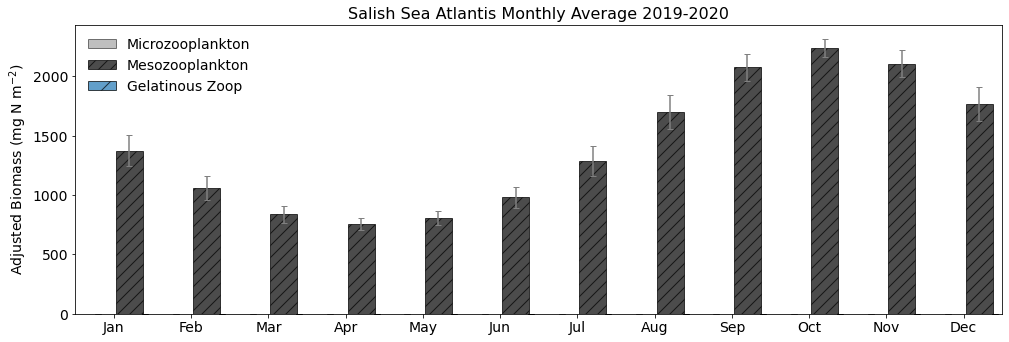

In [80]:
#Check data
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_mesozoo_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssam_microzoo_monthly_mean,width,yerr=ssam_microzoo_std,color='grey',ecolor='dimgrey',edgecolor='k',label='Microzooplankton',alpha=0.5,capsize=3) 
ax.bar(xticks + 0.2, ssam_mesozoo_monthly_mean,width,yerr=ssam_mesozoo_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='Mesozooplankton') 
ax.bar(xticks + 0.4, ssam_gelatzoo_monthly_mean,width,yerr=ssam_gelatzoo_std,edgecolor='k',hatch='/',alpha=0.7,capsize=3,label='Gelatinous Zoop') 
ax.set_title('Salish Sea Atlantis Monthly Average 2019-2020',fontsize=16)
ax.legend(frameon=False,loc='upper left',fontsize=14)
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Adjusted Biomass (mg N m$^{-2}$)',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

### Comparison figures

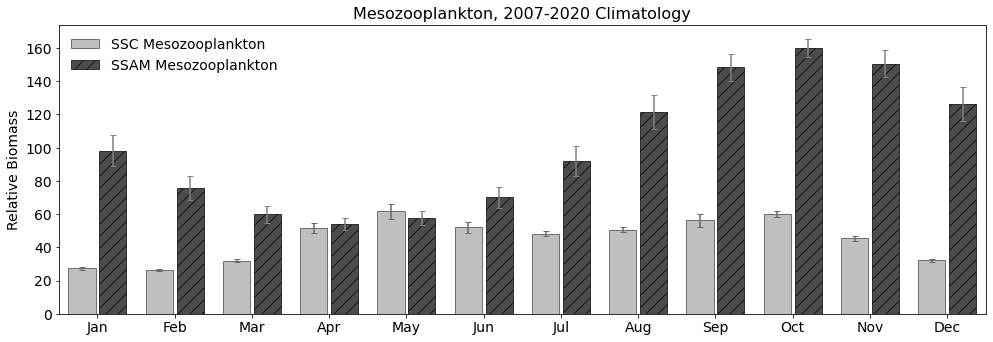

In [81]:
# mesozoo biomass
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_mesozoo_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_mesozoo_monthly_mean,width,yerr=ssc_mesozoo_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSC Mesozooplankton',alpha=0.5,capsize=3) #wheat
ax.bar(xticks + 0.2, ssam_mesozoo_monthly_mean/14,width,yerr=ssam_mesozoo_std/14,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='SSAM Mesozooplankton') #lightgreen
ax.set_title('Mesozooplankton, 2007-2020 Climatology',fontsize=16)
ax.legend(frameon=False,fontsize=14, loc="upper left")
#ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Relative Biomass',fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.text(-.25, 50, "(b)", color='k',fontsize=16)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));

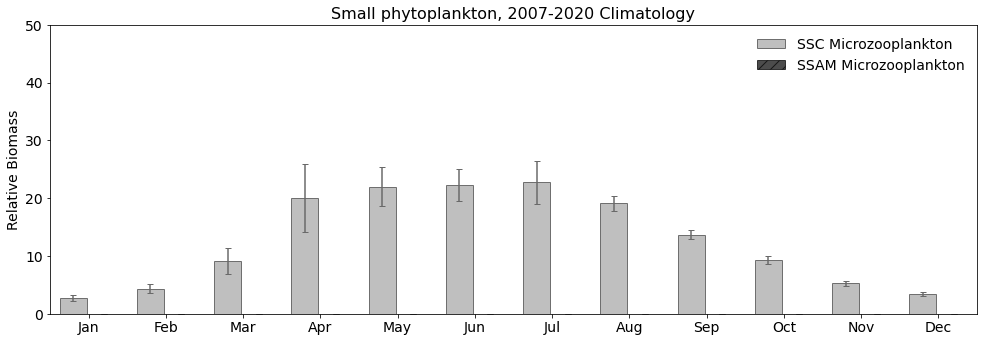

In [82]:
# Picophytoplankton biomass
fig, ax = plt.subplots(figsize=(14, 5))

fig.tight_layout(pad=2.5)

bbox = {'boxstyle': 'round', 'facecolor': 'w', 'alpha': 1}
cmap = plt.get_cmap('tab10')
palette = [cmap(0), cmap(0.2), 'k', cmap(0.1), cmap(0.3)]
xticks=np.arange(len(ssc_microzoo_monthly_mean)) 

width=0.35

ax.bar(xticks-0.2, ssc_microzoo_monthly_mean,width,yerr=ssc_microzoo_std,color='grey',ecolor='dimgrey',edgecolor='k',label='SSC Microzooplankton',alpha=0.5,capsize=3) #wheat
ax.bar(xticks + 0.2, ssam_microzoo_monthly_mean,width,yerr=ssam_microzoo_std,color='k',ecolor='grey',edgecolor='k',hatch='//',alpha=0.7,capsize=3,label='SSAM Microzooplankton') #lightgreen
ax.set_title('Small phytoplankton, 2007-2020 Climatology',fontsize=16)
ax.legend(frameon=False,fontsize=14,loc='upper right') 
ax.set_ylim(0,50)
ax.set_xlim(-.5,11.5)
ax.set_ylabel('Relative Biomass',fontsize=14) 
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
#ax.text(-.25, 45, "(c)", color='k',fontsize=16)
ax.set_xticks(xticks)
ax.set_xticklabels(('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov',"Dec"));